In [67]:
import os
import numpy as np
import matplotlib.pyplot as plt
from Arwin.synthetic_dataset import SyntheticDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
synthetic_dataset = SyntheticDataset(100000, 128, padding=False, verbose=True)

Sampling Functions from Beta Distribution 1/3 with a=2, b=5: 100%|██████████| 33333/33333 [02:02<00:00, 272.93it/s]
Sampling Functions from Beta Distribution 2/3 with a=3, b=3: 100%|██████████| 33333/33333 [01:58<00:00, 281.65it/s]
Sampling Functions from Beta Distribution 3/3 with a=5, b=2: 100%|██████████| 33334/33334 [02:00<00:00, 276.08it/s]
Generating Observations: 100%|██████████| 100000/100000 [00:07<00:00, 14070.58it/s]


[-1.87015641 -1.76878288 -1.65830682 -1.54087165 -1.41869065 -1.29401289
 -1.16909039 -1.04614288 -0.92732369 -0.81468434 -0.71014019 -0.61543496
 -0.53211205 -0.4614797  -0.40458788 -0.36220433 -0.33479593 -0.32251754
 -0.32520465 -0.34237477 -0.37323445 -0.41669376 -0.47138712 -0.53570074
 -0.60780589 -0.68569794 -0.76723677 -0.85019463 -0.93230276 -1.01129982
 -1.08498094 -1.15124538 -1.20814092 -1.25390624 -1.28700838 -1.30617536
 -1.31042168 -1.29907048 -1.27176404 -1.2284709  -1.16948157 -1.0954001
 -1.00712452 -0.9058227  -0.79289883 -0.66995666 -0.53875518 -0.40116339
 -0.25910991 -0.11453454  0.0306614   0.17466162  0.31577641  0.45248074
  0.58344406  0.70755399  0.82393102  0.93193399  1.03115865  1.12142733
  1.20277056  1.27540265  1.33969191  1.39612699  1.44528139  1.48777537
  1.52424035  1.55528581  1.581468    1.60326441  1.62105369  1.63510192
  1.64555429  1.65243525  1.65565144  1.65500447  1.6502045   1.6408908
  1.62665423  1.60706152  1.58167951  1.55010252  1.5

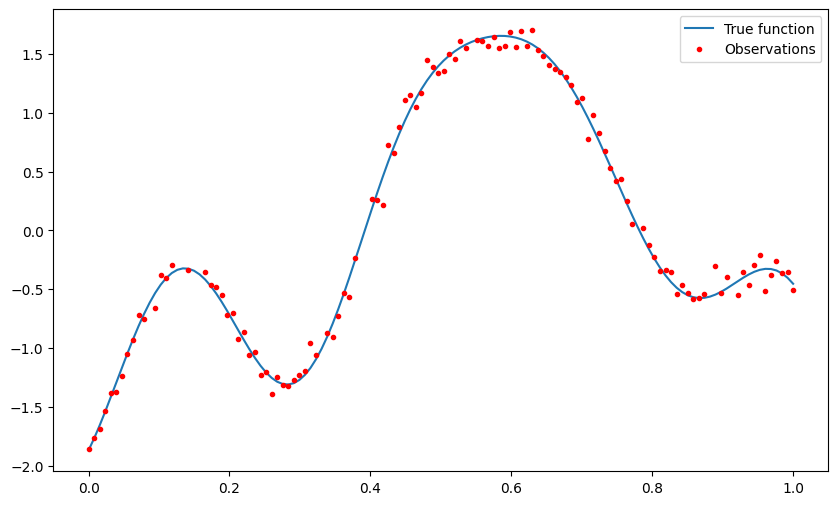

In [3]:
X = np.linspace(0, 1, 128)

for function_values, observations in synthetic_dataset:
    print(function_values)
    observation_values, observation_time_points = observations
    print(observation_time_points)
    print(observation_values)

    plt.figure(figsize=(10,6))
    plt.plot(X, function_values, label='True function')
    plt.plot(observation_time_points, observation_values, marker='.', color='red', linestyle='None', label='Observations')
    plt.legend()
    plt.show()
    break

In [86]:
class ResidualBlock(nn.Module):
    """
    Residual block for the value encoding of the transformer model.
    Following: https://openreview.net/pdf?id=pCbC3aQB5W
    """
    def __init__(self, d_model, hidden_dim, dropout=0.1):
        super(ResidualBlock, self).__init__()
        
        # MLP with one hidden layer
        self.linear1 = nn.Linear(1, hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, d_model)
        
        # Skip connection (fully linear)
        self.skip_connection = nn.Linear(1, d_model)
        
        # Dropout on the output linear layer
        self.dropout = nn.Dropout(dropout)
        
        # Layer normalization at the output
        self.layer_norm = nn.LayerNorm(d_model)
    
    def forward(self, x):
        # Pass through the first linear layer and apply ReLU
        hidden = self.relu(self.linear1(x))
        
        # Pass through the second linear layer and apply dropout
        output = self.dropout(self.linear2(hidden))
        
        # Apply skip connection and layer normalization
        output = self.layer_norm(output + self.skip_connection(x))
        
        return output

In [87]:
"""
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-np.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])
"""

'\nclass PositionalEncoding(nn.Module):\n    def __init__(self, dim_model, dropout_p, max_len):\n        super().__init__()\n        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html\n        # max_len determines how far the position can have an effect on a token (window)\n        \n        # Info\n        self.dropout = nn.Dropout(dropout_p)\n        \n        # Encoding - From formula\n        pos_encoding = torch.zeros(max_len, dim_model)\n        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5\n        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-np.log(10000.0)) / dim_model) # 1000^(2i/dim_model)\n        \n        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))\n        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)\n        \n        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))\n        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)\n 

In [88]:
class TimeSeriesTransformer(nn.Module):
    """
    Transformer model for time series forecasting.
    """
    def __init__(self, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1, max_len=128):
        super(TimeSeriesTransformer, self).__init__()
        
        # Residual block for value encoding
        self.value_linear = nn.Linear(1, d_model)
        self.residual_block = ResidualBlock(d_model, dim_feedforward, dropout)
        
        # Sinusoidal positional encoding for time encoding
        self.time_encoding = self.get_sinusoidal_encoding(max_len, d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layer for predictions
        self.output_layer = nn.Linear(d_model, 1)
    
    def get_sinusoidal_encoding(self, max_len, d_model):
        """
        Create sinusoidal positional encodings for the time steps.
        """
        encoding = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).view(-1, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        
        encoding[:, 0::2] = torch.sin(pos * div_term)  # Apply sin to even indices
        encoding[:, 1::2] = torch.cos(pos * div_term)  # Apply cos to odd indices
        return encoding.unsqueeze(0)  # Add batch dimension
    
    def forward(self, values, times):
        batch_size, L = times.size()
        # Value embedding with residual block
        # shape: [batch, L, d_model]
        value_embedded = self.residual_block(values.unsqueeze(-1))  # Pass through residual block
        
        # Time embedding using sinusoidal encoding
        time_embedded = self.time_encoding[:, :L, :].repeat(batch_size, 1, 1)  # Match batch and sequence length
        
        # Combine time and value embeddings
        x = value_embedded + time_embedded

        # Pass through transformer encoder
        x = self.transformer_encoder(x.permute(1, 0, 2))  # Transformer expects [L, batch, d_model]
        
        # Output prediction for each time step
        output = self.output_layer(x).squeeze(-1)  # shape: [L, batch]
        
        return output.permute(1, 0)  # Return to shape [batch, L]

In [89]:
def collate_fn(batch):
    """
    Collate function for the synthetic dataset.
    Adds variable padding to each batch of the time series sequence.
    """
    # Unpack the batch into function values and observations
    function_values, observations = zip(*batch)
    
    # Convert function values to tensors (in case they’re numpy arrays)
    function_values = torch.stack([torch.tensor(f,dtype=torch.float32) for f in function_values])
    
    # Separate values and times in observations, and convert to tensors
    values, times = zip(*observations)
    values = [torch.tensor(v, dtype=torch.float32) for v in values]
    times = [torch.tensor(t, dtype=torch.float32) for t in times]
    
    # Pad values and times sequences to the length of the longest in the batch
    padded_values = pad_sequence(values, batch_first=True, padding_value=0)
    padded_times = pad_sequence(times, batch_first=True, padding_value=0)
    
    return function_values, (padded_values, padded_times)

Only Transformer Encoder, Full Transformer would also require true function values shifted by one which goes against the specifications of the task. Maybe try only Transformer Decoder.

In [90]:
train_loader = torch.utils.data.DataLoader(dataset=synthetic_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

model = TimeSeriesTransformer().to(device)
X = np.linspace(0, 1, 128)

for function_values, observations in train_loader:
    
    values, times = observations
    values, times = values.to(device), times.to(device)

    output = model(values, times)
    
    print(output.shape)
    break

torch.Size([64, 128])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:292: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
